使用LeNet网络对QuickDraw进行分类
===

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

# 2.导入数据

## 2.1.测试数据集

(28, 28)


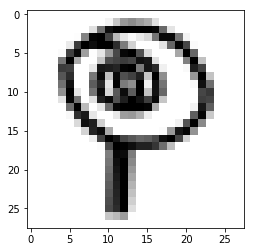

In [3]:
DATA_ROOT = os.path.join("/input/QuickDraw")
CSV_FILE = os.path.join(DATA_ROOT, "quickdraw_png_set1_train.csv")
IMAGE_FILE = os.path.join(DATA_ROOT, "images")

df = pd.read_csv(CSV_FILE, index_col=0)
df.head()

main_dir = IMAGE_FILE

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')

## 2.2.自定义数据集并导入

In [4]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [5]:
BATCH_SIZE = 128

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path=CSV_FILE,
                                 img_dir=IMAGE_FILE,
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4) 


valid_dataset = QuickdrawDataset(txt_path=CSV_FILE,
                                img_dir=IMAGE_FILE,
                                transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4) 



test_dataset = QuickdrawDataset(txt_path=CSV_FILE,
                                img_dir=IMAGE_FILE,
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4) 

# 3.模型

In [6]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [7]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [8]:
def print_sizes(self, input, output):

    print('Inside ' + self.__class__.__name__ + ' forward')
    print('input size:', input[0].size())
    print('output size:', output.data.size())

# 4.训练

In [9]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))


    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE) ))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/8290 | Cost: 2.3064
Epoch: 001/010 | Batch 0500/8290 | Cost: 0.5008
Epoch: 001/010 | Batch 1000/8290 | Cost: 0.6017
Epoch: 001/010 | Batch 1500/8290 | Cost: 0.4216
Epoch: 001/010 | Batch 2000/8290 | Cost: 0.4373
Epoch: 001/010 | Batch 2500/8290 | Cost: 0.4212
Epoch: 001/010 | Batch 3000/8290 | Cost: 0.3912
Epoch: 001/010 | Batch 3500/8290 | Cost: 0.4013
Epoch: 001/010 | Batch 4000/8290 | Cost: 0.4737
Epoch: 001/010 | Batch 4500/8290 | Cost: 0.5046
Epoch: 001/010 | Batch 5000/8290 | Cost: 0.3342
Epoch: 001/010 | Batch 5500/8290 | Cost: 0.5237
Epoch: 001/010 | Batch 6000/8290 | Cost: 0.3753
Epoch: 001/010 | Batch 6500/8290 | Cost: 0.4355
Epoch: 001/010 | Batch 7000/8290 | Cost: 0.4589
Epoch: 001/010 | Batch 7500/8290 | Cost: 0.4232
Epoch: 001/010 | Batch 8000/8290 | Cost: 0.2977
Epoch: 001/010 | Train: 90.718% | Validation: 90.718%
Time elapsed: 5.21 min
Epoch: 002/010 | Batch 0000/8290 | Cost: 0.2151
Epoch: 002/010 | Batch 0500/8290 | Cost: 0.1875
Epoch: 002/

Epoch: 010/010 | Batch 2000/8290 | Cost: 0.2143
Epoch: 010/010 | Batch 2500/8290 | Cost: 0.2201
Epoch: 010/010 | Batch 3000/8290 | Cost: 0.1785
Epoch: 010/010 | Batch 3500/8290 | Cost: 0.1711
Epoch: 010/010 | Batch 4000/8290 | Cost: 0.2276
Epoch: 010/010 | Batch 4500/8290 | Cost: 0.2888
Epoch: 010/010 | Batch 5000/8290 | Cost: 0.1930
Epoch: 010/010 | Batch 5500/8290 | Cost: 0.2556
Epoch: 010/010 | Batch 6000/8290 | Cost: 0.3380
Epoch: 010/010 | Batch 6500/8290 | Cost: 0.2052
Epoch: 010/010 | Batch 7000/8290 | Cost: 0.2354
Epoch: 010/010 | Batch 7500/8290 | Cost: 0.2767
Epoch: 010/010 | Batch 8000/8290 | Cost: 0.2702
Epoch: 010/010 | Train: 93.001% | Validation: 93.001%
Time elapsed: 50.20 min
Total Training Time: 50.20 min


# 5.评估

In [10]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 93.00%


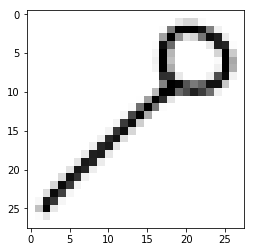

In [11]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
nhwc_img = np.transpose(features[5], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [12]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Washing Machine %.2f%%' % (probas[0][4]*100))

Probability Washing Machine 0.12%
